In [1]:
import os
import re
import sys
sys.path.append('../')
import json
import pywt

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import simpson
from sklearn.linear_model import RidgeClassifierCV
from tqdm import tqdm
from typing import List
from transform import TimeSeriesTransform
from concurrent.futures import ThreadPoolExecutor, as_completed

In [2]:
cfg = json.load(open("../config/config.json"))

ts_trans = TimeSeriesTransform(cfg)

In [3]:
INSTANCES_DIR = '../data/linear_acuator/instances/'
INFERENCE_DIR = '../data/linear_acuator/inference/'
STATES = ['normal', 
            'backlash1', 'backlash2',
            'lackLubrication1', 'lackLubrication2',
            'spalling1', 'spalling2', 'spalling3', 'spalling4', 'spalling5', 'spalling6', 'spalling7', 'spalling8']
LOADS= ['20kg', '40kg', '-40kg']

In [4]:
load = '20kg'
filenames_20kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_20kg = [filename for sublist in filenames_20kg for filename in sublist]

load = '40kg'
filenames_40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_40kg = [filename for sublist in filenames_40kg for filename in sublist]

load = '-40kg'
filenames_m40kg = [os.listdir(os.path.join(INSTANCES_DIR, load, state)) for state in STATES]
filenames_m40kg = [filename for sublist in filenames_m40kg for filename in sublist]

In [5]:
def get_X_y(filenames, load, is_train=True):
    X, y = [], []
    data_dir = INSTANCES_DIR if is_train else INFERENCE_DIR
    for filename in filenames:
        load_num = load[:-2]
        state = re.match(fr'(.*)_{load_num}', filename).group(1)
        df = pd.read_csv(os.path.join(data_dir, load, state, filename))
        tmp_cur = ts_trans.smoothing(ts_df=df, field='current')
        # tmp_pos = ts_transform.smoothing(ts_df=df, field='position_error')
        X.append(tmp_cur)
        y.append(state)
    return np.array(X), np.array(y)

In [6]:
X_20kg, y_20kg = get_X_y(filenames_20kg, load='20kg')
X_40kg, y_40kg = get_X_y(filenames_40kg, load='40kg')
X_m40kg, y_m40kg = get_X_y(filenames_m40kg, load='-40kg')

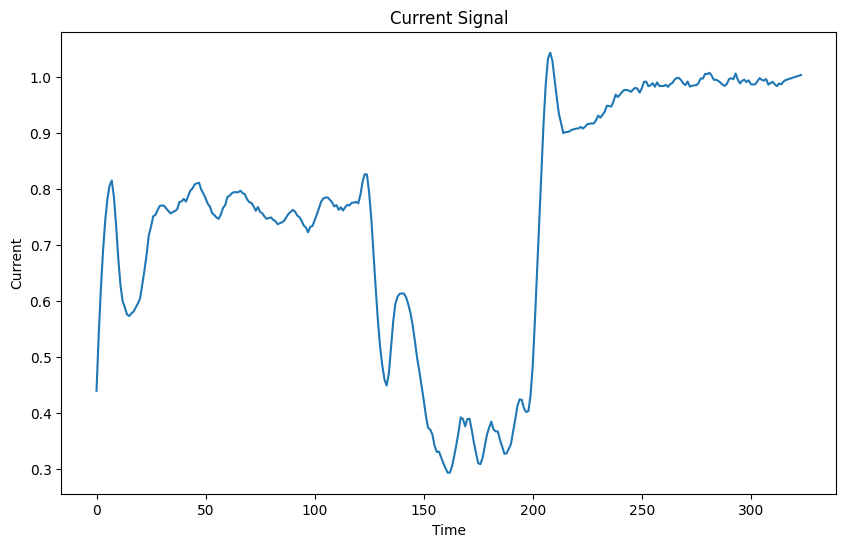

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Current')
plt.title('Current Signal')
plt.show()

In [8]:
# Z-normalize the time series data
z_normalized_X_20kg = (X_20kg - np.mean(X_20kg, axis=1, keepdims=True)) / np.std(X_20kg, axis=1, keepdims=True)
z_normalized_X_40kg = (X_40kg - np.mean(X_40kg, axis=1, keepdims=True)) / np.std(X_40kg, axis=1, keepdims=True)
z_normalized_X_m40kg = (X_m40kg - np.mean(X_m40kg, axis=1, keepdims=True)) / np.std(X_m40kg, axis=1, keepdims=True)

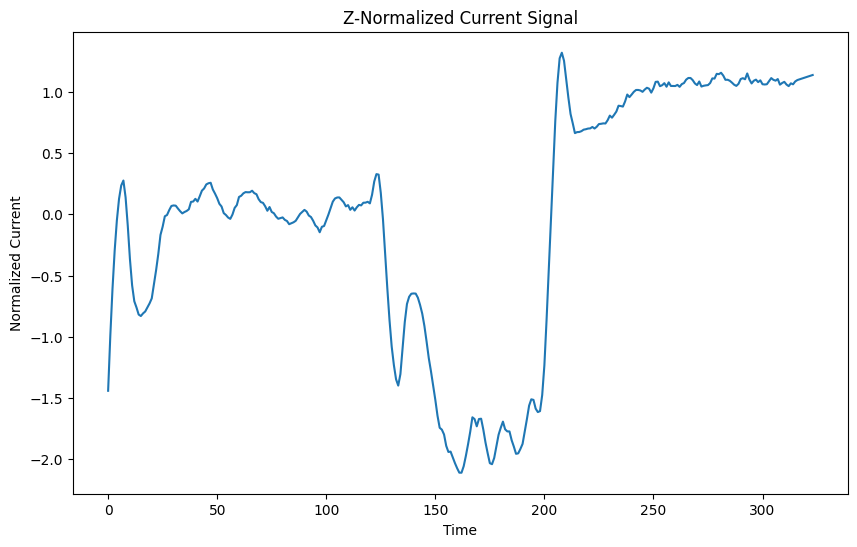

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(z_normalized_X_20kg[0])
plt.xlabel('Time')
plt.ylabel('Normalized Current')
plt.title('Z-Normalized Current Signal')
plt.show()

In [10]:
lower_bound = 1   # Lower bound of the range (inclusive)
upper_bound = X_20kg.shape[-1] // 2 # Upper bound of the range (exclusive)
n_kernels = 2000
np.random.seed(42)  # for reproducibility
random_scales = np.random.uniform(lower_bound, upper_bound, n_kernels)
wavelet = 'mexh' 

In [11]:
def simpsons_integral(x, y):
    """
    Approximates the integral of a function given by data points (x, y) using Simpson's rule.

    Parameters:
        x (array-like): Array of x values (must be evenly spaced).
        y (array-like): Array of y values corresponding to f(x) at each x.

    Returns:
        float: Approximate integral of the function.
    """
    # Ensure an even number of intervals
    if (len(x) - 1) % 2 != 0:
        x = x[:-1]
        y = y[:-1]

    n = len(x) - 1
    h = (x[-1] - x[0]) / n
    
    # Apply Simpson's rule formula
    integral = y[0] + y[-1] + 4 * np.sum(y[1:-1:2]) + 2 * np.sum(y[2:-2:2])
    integral *= h / 3
    return integral

In [13]:
coefficients, freqs = pywt.cwt(z_normalized_X_20kg[0], random_scales, wavelet, method='conv')
coefficients.shape

(2000, 324)

In [14]:
x_arr = np.arange(0, len(coefficients[0]))
x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
x_arr.shape

(2000, 324)

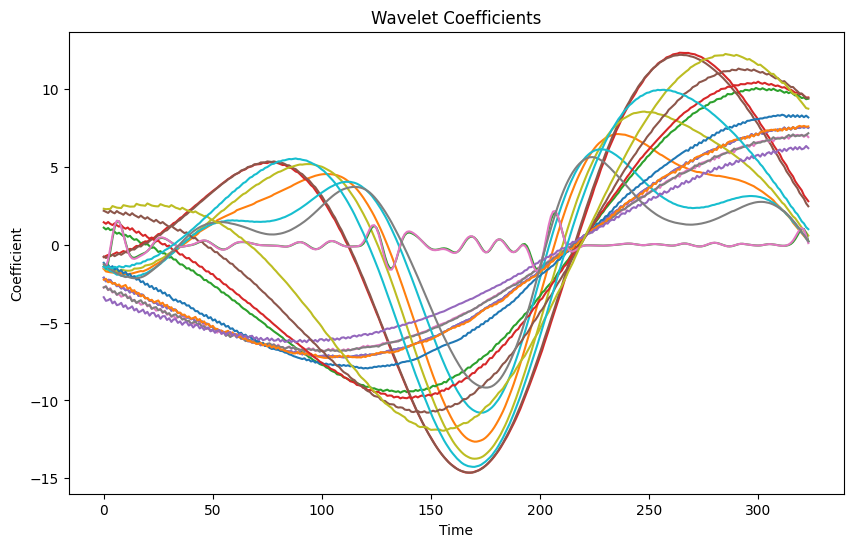

In [15]:
plt.figure(figsize=(10, 6))

for _ in range(20):
    rand_idx = np.random.randint(coefficients.shape[0])
    plt.plot(x_arr[0], coefficients[rand_idx])

plt.xlabel('Time')
plt.ylabel('Coefficient')
plt.title('Wavelet Coefficients')
plt.show()

In [16]:
res = np.array([trapezoidal_integral(x_arr[i], coefficients[i]) for i in range(coefficients.shape[0])])
print(f'After integral: {res.shape}')
res

After integral: (2000,)


array([ 204.58616584, -554.94539434, -485.99173402, ...,   25.29500577,
         19.49600409,  248.10708275])

In [17]:
res = np.array([simpsons_integral(x_arr[i], coefficients[i]) for i in range(coefficients.shape[0])])
print(f'After integral: {res.shape}')
res

After integral: (2000,)


array([ 198.8438235 , -561.52309722, -494.71078917, ...,   25.0769675 ,
         19.15862809,  245.94670023])

In [18]:
ppv = (coefficients > 0).sum(axis=-1) / coefficients.shape[-1]
print(f'After ppv: {ppv.shape}')
ppv

After ppv: (2000,)


array([0.62345679, 0.33950617, 0.33024691, ..., 0.64506173, 0.62654321,
       0.62037037])

In [19]:
def raven(sample, random_scales, wavelet, integral):
    coefficients, _ = pywt.cwt(sample, random_scales, wavelet, method='conv')
    x_arr = np.arange(0, len(coefficients[0]))
    x_arr = np.tile(x_arr, (coefficients.shape[0], 1))
    integral = np.array([integral(x_arr[i], coefficients[i]) for i in range(coefficients.shape[0])])
    return integral

def raven_parallel(X, random_scales, wavelet, integral, max_workers=8):
    raven_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(raven, X[i], random_scales, wavelet, integral) for i in range(len(X))]
        for future in tqdm(futures):
            raven_results.append(future.result())
    return raven_results

In [20]:
def raven_ppvs(sample, random_scales, wavelet):
    coefficients, _ = pywt.cwt(sample, random_scales, wavelet, sampling_period=1/400)
    ppvs = (coefficients > 0).sum(axis=-1) / coefficients.shape[-1]
    return ppvs

def raven_ppvs_parallel(X, random_scales, wavelet, max_workers=8):
    raven_results = []
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(raven_ppvs, X[i], random_scales, wavelet) for i in range(len(X))]
        for future in tqdm(futures):
            raven_results.append(future.result())
    return raven_results

In [21]:
raven_results_20kg_p = raven_parallel(z_normalized_X_20kg, random_scales, wavelet, simpsons_integral)
ridge_20 = RidgeClassifierCV()
ridge_20.fit(raven_results_20kg_p, y_20kg)
print(f'20kg: {ridge_20.score(raven_results_20kg_p, y_20kg)}')

100%|██████████| 455/455 [00:48<00:00,  9.29it/s]


20kg: 0.945054945054945


In [22]:
raven_results_40kg_p = raven_parallel(z_normalized_X_40kg, random_scales, wavelet, simpsons_integral)

ridge_40 = RidgeClassifierCV()
ridge_40.fit(raven_results_40kg_p, y_40kg)
print(f'40kg: {ridge_40.score(raven_results_40kg_p, y_40kg)}')

100%|██████████| 452/452 [00:48<00:00,  9.26it/s]


40kg: 1.0


In [23]:
raven_results_m40kg_p = raven_parallel(z_normalized_X_m40kg, random_scales, wavelet, simpsons_integral)

ridge_m40 = RidgeClassifierCV()
ridge_m40.fit(raven_results_m40kg_p, y_m40kg)
print(f'-40kg: {ridge_m40.score(raven_results_m40kg_p, y_m40kg)}')

100%|██████████| 455/455 [00:49<00:00,  9.25it/s]


-40kg: 0.9494505494505494


In [24]:
load = '20kg'
filenames_20kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_20kg_t = [filename for sublist in filenames_20kg_t for filename in sublist]

load = '40kg'
filenames_40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_40kg_t = [filename for sublist in filenames_40kg_t for filename in sublist]

load = '-40kg'
filenames_m40kg_t = [os.listdir(os.path.join(INFERENCE_DIR, load, state)) for state in STATES]
filenames_m40kg_t = [filename for sublist in filenames_m40kg_t for filename in sublist]

In [25]:
X_20kg_t, y_20kg_t = get_X_y(filenames_20kg_t, load='20kg', is_train=False)
X_40kg_t, y_40kg_t = get_X_y(filenames_40kg_t, load='40kg', is_train=False)
X_m40kg_t, y_m40kg_t = get_X_y(filenames_m40kg_t, load='-40kg', is_train=False)

In [26]:
z_normalized_X_20kg_t = (X_20kg_t - np.mean(X_20kg_t, axis=1, keepdims=True)) / np.std(X_20kg_t, axis=1, keepdims=True) 
z_normalized_X_40kg_t = (X_40kg_t - np.mean(X_40kg_t, axis=1, keepdims=True)) / np.std(X_40kg_t, axis=1, keepdims=True)
z_normalized_X_m40kg_t = (X_m40kg_t - np.mean(X_m40kg_t, axis=1, keepdims=True)) / np.std(X_m40kg_t, axis=1, keepdims=True)

In [30]:
raven_results_20kg_t = raven_parallel(z_normalized_X_20kg_t, random_scales, wavelet, simpsons_integral)
ridge_20.score(raven_results_20kg_t, y_20kg_t)

100%|██████████| 195/195 [00:21<00:00,  9.28it/s]


0.6358974358974359

In [31]:
raven_results_40kg_t = raven_parallel(z_normalized_X_40kg_t, random_scales, wavelet, simpsons_integral)
ridge_40.score(raven_results_40kg_t, y_40kg_t)

100%|██████████| 193/193 [00:21<00:00,  9.14it/s]


0.7046632124352331

In [32]:
raven_result_m40kg_t = raven_parallel(z_normalized_X_m40kg_t, random_scales, wavelet, simpsons_integral)
ridge_m40.score(raven_result_m40kg_t, y_m40kg_t)

  0%|          | 0/195 [00:00<?, ?it/s]

100%|██████████| 195/195 [00:21<00:00,  9.26it/s]


0.6051282051282051

## Use ROCKET for Comparison

In [119]:
from pyts.transformation import ROCKET

rocket = ROCKET(random_state=0)

rocket.fit(X_20kg)

rocket_results_20kg = rocket.transform(X_20kg)
rocket_results_20kg_t = rocket.transform(X_20kg_t)
rocket_20 = RidgeClassifierCV()
rocket_20.fit(rocket_results_20kg, y_20kg)
print(f'20kg train: {rocket_20.score(rocket_results_20kg, y_20kg)}')
print(f'20kg test: {rocket_20.score(rocket_results_20kg_t, y_20kg_t)}')

20kg train: 0.9973262032085561
20kg test: 0.7307692307692307


In [122]:
rocket.fit(X_40kg)

rocket_results_40kg = rocket.transform(X_40kg)
rocket_results_40kg_t = rocket.transform(X_40kg_t)
rocket_40 = RidgeClassifierCV()
rocket_40.fit(rocket_results_40kg, y_40kg)
print(f'40kg train: {rocket_40.score(rocket_results_40kg, y_40kg)}')
print(f'40kg test: {rocket_40.score(rocket_results_40kg_t, y_40kg_t)}')

40kg train: 1.0
40kg test: 0.7209302325581395


In [123]:
rocket.fit(X_m40kg)

rocket_results_m40kg = rocket.transform(X_m40kg)
rocket_results_m40kg_t = rocket.transform(X_m40kg_t)
rocket_m40 = RidgeClassifierCV()
rocket_m40.fit(rocket_results_m40kg, y_m40kg)
print(f'm40kg train: {rocket_m40.score(rocket_results_m40kg, y_m40kg)}')
print(f'-40kg test: {rocket_m40.score(rocket_results_m40kg_t, y_m40kg_t)}')

m40kg train: 1.0
-40kg test: 0.7615384615384615
